# Selector + Operation

In [1]:
#from models.nalu import NALU
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook as tqdm
from torch.optim import Adam
from models_new.nalu import NALU
import torch
import torchvision.utils as vutils
import numpy as np
import torchvision.models as models
from torchvision import datasets
from tensorboardX import SummaryWriter
import datetime
import os

In [2]:
def generate_synthetic_arithmetic_dataset(arithmetic_op, min_value, max_value, sample_size, set_size, boundaries = None):
    """
    generates a dataset of integers for the synthetics arithmetic task

    :param arithmetic_op: the type of operation to perform on the sum of the two sub sections can be either :
    ["add" , "subtract", "multiply", "divide", "root", "square"]
    :param min_value: the minimum possible value of the generated integers
    :param max_value: the maximum possible value of the generated integers
    :param sample_size: the number of integers per sample
    :param set_size: the number of samples in the dataset
    :param boundaries: [Optional] an iterable of 4 integer indices in the following format :
    [start of 1st section, end of 1st section, start of 2nd section, end of 2nd section]
    if None, the boundaries are randomly generated.
    :return: the training dataset input, the training true outputs, the boundaries of the sub sections used
    """
    scaled_input_values = np.random.uniform(min_value, max_value, (set_size, sample_size))

    if boundaries is None:
        boundaries = [np.random.randint(sample_size) for i in range(4)]
        boundaries = sorted(boundaries)
        
        if boundaries[1] == boundaries[0]:
            if boundaries[1] < sample_size-1:
                boundaries[1] =boundaries[1]+ 1
            else:
                boundaries[0] = boundaries[0] - 1
        if boundaries[3] == boundaries[2]:
            if boundaries[3] < sample_size-1:
                boundaries[3] =boundaries[3]+ 1
            else:
                boundaries[2] =boundaries[2]- 1
    else:
        if len(boundaries) != 4:
            raise ValueError("boundaries is expected to be a list of 4 elements but found {}".format(len(boundaries)))

    a = np.array([np.sum(sample[boundaries[0]:boundaries[1]]) for sample in scaled_input_values])
    b = np.array([np.sum(sample[boundaries[2]:boundaries[3]]) for sample in scaled_input_values])

    true_outputs = None
    if "add" in str.lower(arithmetic_op):
        true_outputs = a + b
    elif "sub" in str.lower(arithmetic_op):
        true_outputs = a - b
    elif "mult" in str.lower(arithmetic_op):
        true_outputs = a * b
    elif "div" in str.lower(arithmetic_op):
        true_outputs = a / b
    elif "square" == str.lower(arithmetic_op):
        true_outputs = a * a
    elif "root" in str.lower(arithmetic_op):
        true_outputs = np.sqrt(a)
    
    scaled_input_values = torch.tensor(scaled_input_values, dtype=torch.float32)
    true_outputs = torch.tensor(true_outputs, dtype=torch.float32).unsqueeze(1)
        
    return scaled_input_values, true_outputs, boundaries

# Training

In [15]:
list_of_loss_train = []
list_of_loss_test = []
FEATURES_NUM = 100
epochs = 1000
batch_size = 10
lr = 0.01
#lr = 0.001
operator = "add"
accuracy = []
exp_training_loss_end = []
exp_test_loss_end = []
ini = ['Kai_uni','Xav_norm','Kai_norm','Zeros','Ones']
res = []

for init in ini:
    print('Using {}'.format(init))
    for exp in range(5):        
        training_loss = []
        test_loss = []

        stop_training = False
        np.random.seed(exp)

        in_dim = FEATURES_NUM
        hidden_dim = 2
        out_dim = 1
        num_layers = 2

        dim = in_dim # dimensition for generating data

        model = NALU(num_layers, in_dim, hidden_dim, out_dim, init)

        X_train, y_train, boundaries = generate_synthetic_arithmetic_dataset(operator, 0, 10, FEATURES_NUM, 1000)
        X_test, y_test, _ = generate_synthetic_arithmetic_dataset(operator, 0, 100, FEATURES_NUM, 1000, boundaries)

        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

        for epoch in tqdm(range(epochs)):
            batch_loss_training = []

            for batch in range(len(X_train) // batch_size):

                model.train()
                optimizer.zero_grad()

                X_batch_train = X_train[batch:(batch+batch_size),:]
                y_batch_train = y_train[batch:(batch+batch_size),:]

                out = model(X_batch_train)

                loss = F.mse_loss(out, y_batch_train)

                loss.backward()
                optimizer.step()
                batch_loss_training.append(loss.item())


            if epoch % 10 == 1:

                model.eval()

                X_batch_test = X_test[batch:(batch+batch_size),:]
                y_batch_test = y_test[batch:(batch+batch_size),:]

                output_test = model(X_batch_test)
                loss = F.mse_loss(output_test, y_batch_test)

                acc = np.sum(np.isclose(output_test.detach().numpy(), y_batch_test.detach().numpy(), atol=.1, rtol=0)) / len(y_batch_test)
                accuracy.append(acc)
                test_loss.append(loss.item())


                training_loss.append(np.mean(batch_loss_training))


        exp_training_loss_end.append(training_loss[-1])
        exp_test_loss_end.append(test_loss[-1])
        list_of_loss_train.append(training_loss)
        list_of_loss_test.append(test_loss)
        
    counter_test = 0

    for i in range(len(exp_test_loss_end)):
        if exp_test_loss_end[i] < 10**(-5) : 
            counter_test = counter_test +  1

    counter_train = 0
    for i in range(len(exp_training_loss_end)):
        if exp_training_loss_end[i] < 10**(-5) : 
            counter_train = counter_train + 1

    r1 = [training_loss[-1],test_loss[-1],counter_train,counter_test]
    res.append(r1)

Using Kai_uni


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Using Xav_norm


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Using Kai_norm


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Using Zeros


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Using Ones


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [16]:
res

[[2.0711775922777064e-07, 0.0021680325735360384, 3, 1],
 [22.613696756362916, 2934165.25, 5, 1],
 [204.88025905609132, 62018388230144.0, 5, 1],
 [0.26538082216167824, 10.554849624633789, 5, 1],
 [0.2620142688101623, nan, 5, 1]]

In [20]:
list_of_loss_train[0]

[120.13027976989746,
 18.57073581814766,
 8.400064409971238,
 4.713741507232189,
 22.990988431572916,
 2.260448326319456,
 1.1025985857844354,
 1.962993830293417,
 1.3128547428548336,
 1.0884105920419096,
 0.9411080279946327,
 0.8382795470394194,
 0.7282962932810187,
 0.6697156518511475,
 0.6147915904596448,
 0.5691526076756418,
 0.5306773266289383,
 0.4964888675883412,
 0.4657617356441915,
 0.4380149782123044,
 0.41284499839879574,
 0.3904071368742734,
 0.3701355697028339,
 0.35174546918366106,
 0.33516947536729275,
 0.3197760646836832,
 0.30550891981460154,
 0.2921749800024554,
 0.27994787331670523,
 0.26838267255574466,
 0.2575910910777748,
 0.24787452620919795,
 0.2384037742065266,
 0.2296585856936872,
 0.22136984009761362,
 0.21346942137926816,
 0.20621629358269275,
 0.19940592526458203,
 0.1929607209889218,
 0.18681854095542805,
 0.18095449659740553,
 0.175347124224063,
 0.16997341273585334,
 0.16482267421903088,
 0.15989948692033068,
 0.15514613733161242,
 0.1505544881988317,
 0

# Count training convergence

In [7]:
counter_test = 0

for i in range(len(exp_test_loss_end)):
    if exp_test_loss_end[i] < 10**(-5) : 
        counter_test = counter_test +  1

print('Test counter: ',counter_test)

counter_train = 0
for i in range(len(exp_training_loss_end)):
    if exp_training_loss_end[i] < 10**(-5) : 
        counter_train = counter_train + 1

print('Training counter: ', counter_train)

print('End training loss: ', training_loss[-30:-1])
print('End test loss: ', test_loss[-30:-1])
print(np.min(training_loss))
print(np.min(test_loss))
#np.sum(np.isnan(test_loss))

Test counter:  0
Training counter:  0
End training loss:  [0.27651471851742826, 0.2775545186060481, 0.2756086333945859, 0.2767896930593997, 0.27594565678038635, 0.2754470224608667, 0.27507415640400723, 0.27399906316190026, 0.2739252227148972, 0.2743798300414346, 0.272643139680149, 0.2737914646277204, 0.2722254463180434, 0.272643052409403, 0.2711574369727168, 0.27317521045799364, 0.27099761285004204, 0.27065516786067745, 0.27074013218516485, 0.26919500194489954, 0.2691469437943306, 0.26821889936807564, 0.2686574561696034, 0.26812958904891276, 0.2680469004891347, 0.26759858573437667, 0.2670444395649247, 0.26668022883939557, 0.2663620054186322]
End test loss:  [10.496476173400879, 10.103463172912598, 10.70067310333252, 10.14974594116211, 10.111923217773438, 10.211113929748535, 10.241719245910645, 10.626330375671387, 10.461559295654297, 10.088356971740723, 10.399408340454102, 10.216418266296387, 10.593623161315918, 10.27822208404541, 10.745196342468262, 10.201028823852539, 10.3336248397827

# Plots training loss

IndexError: list index out of range

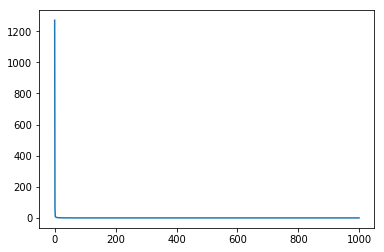

In [6]:
experi = 0
plt.plot(list_of_loss_train[experi])
plt.plot(training_loss)
#len(list_of_loss_train[9])

# Plots test loss

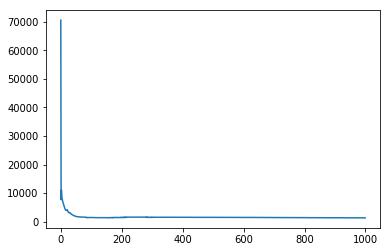

In [7]:
plt.plot(test_loss)
plt.plot(list_of_loss_test[experi])

# Only Selector

In [22]:
from data_generator_helper import generate_synthetic_selection_dataset

In [23]:
def train(model, optimizer, x_train, y_train, epochs, batch_size):
    for epoch in range(epochs):

        for batch in range(len(x_train) // batch_size):

            model.train()
            optimizer.zero_grad()

            x_batch_train = x_train[batch:(batch+batch_size),:]
            y_batch_train = y_train[batch:(batch+batch_size),:]

            out = model(x_batch_train)

            loss = F.mse_loss(out, y_batch_train)
            
            #if loss != loss:
            #    print("nan detected")
            
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0: 
            print(epoch)
            #reportLoss(loss.data)
            
    return test(model,x_train,y_train)
        
def test(model, x_test, y_test):
    
    model.eval()
    output_test = model(x_test)
    loss = F.mse_loss(output_test, y_test)
    
    return loss

In [26]:
test_per_range = 10
sample_size = 100
set_size = 1000
res_new = []
in_dim = sample_size
hidden_dim = 1
out_dim = 2
num_layers = 1

lr = 0.01
epochs = 500
batch_size = 1
ini = ['Kai_uni','Xav_norm','Kai_norm','Zeros','Ones']

train_loss = []
test_loss = []

min_value = 1
max_value = 100
    
    #train_acc = 0
    #test_acc = 0
for init in ini:
    print('Using {}'.format(init))
    for i in range(test_per_range):

        model = NALU(num_layers, in_dim, hidden_dim, out_dim, init)
        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)

        x_train, y_train, boundaries = generate_synthetic_selection_dataset(min_value, max_value,
                                                                    sample_size, set_size, boundaries = None)
        x_test, y_test, _ = generate_synthetic_selection_dataset(min_value, max_value*10,
                                                                    sample_size, set_size, boundaries = boundaries)

        train_loss.append(train(model, optimizer, x_train, y_train, epochs, batch_size).item())

        test_loss.append(test(model, x_test, y_test).item())

        print('Model {} finished'.format(i))
    
    counter_test = 0

    for i in range(len(exp_test_loss_end)):
        if exp_test_loss_end[i] < 10**(-5) : 
            counter_test = counter_test +  1

    counter_train = 0
    for i in range(len(exp_training_loss_end)):
        if exp_training_loss_end[i] < 10**(-5) : 
            counter_train = counter_train + 1

    r1 = [train_loss[-1],test_loss[-1],counter_train,counter_test]
    res_new.append(r1)
    

Using Kai_uni
Model 0 finished
Model 1 finished
Model 2 finished
Model 3 finished
Model 4 finished
Model 5 finished
Model 6 finished
Model 7 finished
Model 8 finished
Model 9 finished
Using Xav_norm
Model 0 finished
Model 1 finished
Model 2 finished
Model 3 finished
Model 4 finished
Model 5 finished
Model 6 finished
Model 7 finished
Model 8 finished
Model 9 finished
Using Kai_norm
Model 0 finished
Model 1 finished
Model 2 finished
Model 3 finished
Model 4 finished
Model 5 finished
Model 6 finished
Model 7 finished
Model 8 finished
Model 9 finished
Using Zeros
Model 0 finished
Model 1 finished
Model 2 finished
Model 3 finished
Model 4 finished
Model 5 finished
Model 6 finished
Model 7 finished
Model 8 finished
Model 9 finished
Using Ones
Model 0 finished
Model 1 finished
Model 2 finished
Model 3 finished
Model 4 finished
Model 5 finished
Model 6 finished
Model 7 finished
Model 8 finished
Model 9 finished


In [27]:
res_new

[[nan, nan, 5, 1],
 [2.865723237647857e+27, inf, 5, 1],
 [11613.958984375, 3616953344.0, 5, 1],
 [24408.642578125, 3489939712.0, 5, 1],
 [nan, nan, 5, 1]]

In [5]:
counter_test = 0

for i in range(len(test_loss)):
    if test_loss[i] < 10**(-5) : 
        counter_test = counter_test +  1



counter_train = 0
for i in range(len(train_loss)):
    if train_loss[i] < 10**(-5) : 
        counter_train = counter_train + 1




print('Training loss: ', np.min(train_loss))
print('Training convergence counter: ', counter_train)
print('Test loss: ', np.min(test_loss))
print('Test convergence counter: ',counter_test)

Training loss:  nan
Training convergence counter:  2
Test loss:  nan
Test convergence counter:  2


/Users/Rollo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [6]:
test_loss

[9.825918745320905e-09,
 nan,
 nan,
 1189817088.0,
 nan,
 5.652128542976698e-09,
 41657126912.0,
 inf,
 nan,
 nan]

In [39]:
for i in range(len(train_loss)):
    train_loss[i] = train_loss[i].item()

<BarContainer object of 10 artists>

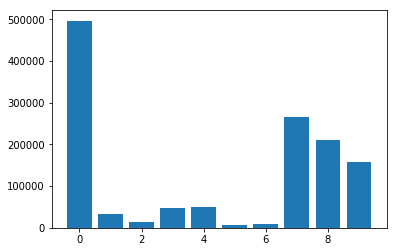

In [40]:
experiment = [0,1,2,3,4,5,6,7,8,9]
plt.bar(experiment,train_loss)

<BarContainer object of 10 artists>

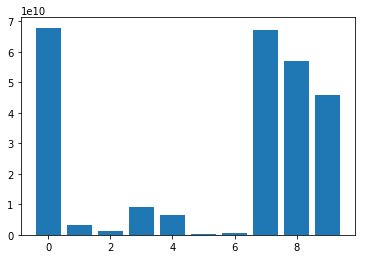

In [41]:
plt.bar(experiment,test_loss)

In [42]:
test_loss

[67851460608.0,
 3207258112.0,
 1089331968.0,
 9176840192.0,
 6479894528.0,
 367005728.0,
 603412992.0,
 67081310208.0,
 56864288768.0,
 45750366208.0]

tensor([[22973.8887,   790.1139],
        [24995.5020,   924.3483],
        [20814.7070,   379.1037],
        ...,
        [27380.1973,   780.3442],
        [22121.5859,   342.2463],
        [22834.5605,   404.0862]])